# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


**Инструкция по выполнению проекта**
- Загрузите и подготовьте данные. Поясните порядок действий.
- Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
- Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
- Проведите финальное тестирование.

**Признаки**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента1

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score

data = pd.read_csv('/datasets/Churn.csv')


data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [2]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [3]:
len(data['CustomerId'].unique())

10000

Тип данных Tenure - float64, такой тип присвоен из-за пропусков. Попробуем избавиться от пропусков и приветси к целочисленному значению.

In [4]:
data.dropna(subset=['Tenure'], inplace=True)
data['Tenure']=data['Tenure'].astype('int')

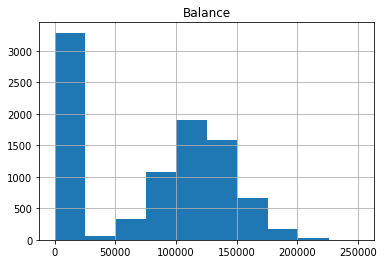

In [5]:
data.hist('Balance')
plt.show()

In [6]:
zero_balance=data.query('Balance==0')
print('Клиентов с нулевым балансом:',len(zero_balance))
zero_balance.head()

Клиентов с нулевым балансом: 3283


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0           1    15634602  Hargrave          619    France  Female   42   
3           4    15701354      Boni          699    France  Female   39   
6           7    15592531  Bartlett          822    France    Male   50   
11         12    15737173   Andrews          497     Spain    Male   24   
12         13    15632264       Kay          476    France  Female   34   

    Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0        2      0.0              1          1               1   
3        1      0.0              2          0               0   
6        7      0.0              2          1               1   
11       3      0.0              2          1               0   
12      10      0.0              2          1               0   

    EstimatedSalary  Exited  
0         101348.88       1  
3          93826.63       0  
6          10062.80       0  
11         76390.01       0  
12         26260.98       0

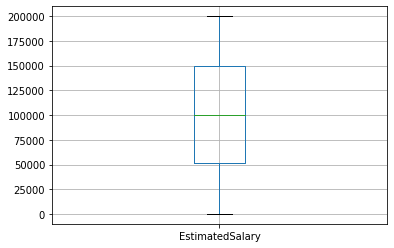

In [7]:
data.boxplot('EstimatedSalary')
plt.show()

Датасет состоит из 10 000 объектов и 14 признаков. Из них для обучения модели нам не понадобятся:

- RowNumber индекс строки в данных;
- CustomerId уникальный идентификатор;
- Surname фамилия клиента.


Целевой признак для нашей задачи – Exited, т.е. модель, которую мы попытаемся построить, будет предсказывать значение 1 если клиент уйдет или 0 если нет. В этом заключается наша задача классификации, т.к. целевой признак является категориальным.

**Займемся подготовкой выборок для дальнейшего обучения моделей**

In [8]:
len(data.query('EstimatedSalary < 20_000'))

909

Можно удалить признаки, которые нам не нужны.

In [9]:
data=data.drop(columns=['RowNumber','CustomerId','Surname'])

In [10]:
rnd_state = 2020

Добавим функции для упрощения дальнейшей работы.

In [11]:
def tf(data, target_column='Exited'):
    '''Функция возвращает целевой признак и признаки для обучения модели.'''    
    target = data[target_column]
    features = data.drop(target_column, axis=1)
    return target, features

In [12]:
def split_data(features, target):
    '''
    Функция разделяет заданный датасет на обучающую, валидационную и тестовую выборки:
    60% | 20% | 20%
    '''
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.4, random_state=rnd_state
    )

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=0.5, random_state=rnd_state
    )
    
    # выполним масштабирование количественных признаков
    scaler = StandardScaler()
    numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [13]:
def train_and_predict(data, model, log_prefix='', samplefunc=None, test=False):
    '''Функция возвращает обученную модель.'''
    target, features = tf(data)
    features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
    
    if samplefunc:
        features_train, target_train = samplefunc(features_train, target_train)
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(f'{log_prefix}F1-мера на валидационной выборке: {f1_score(target_valid, predicted_valid)}')
    
    if test:
        predictions_test = model.predict(features_test)
        print(f'{log_prefix}F1-мера на тестовой выборке: {f1_score(target_test, predicted_test)}')
    
    return model

# 2. Исследование задачи

Посмотрим как часто в целевом признаке встречается класс 1 или 0

0    0.796062
1    0.203938
Name: Exited, dtype: float64


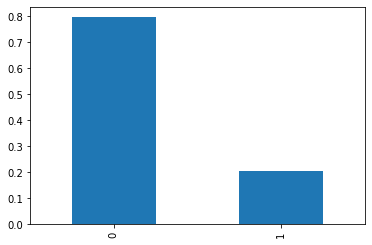

In [14]:
class_frequency = data['Exited'].value_counts(normalize=True)
class_frequency.plot(kind='bar')
print(class_frequency)
plt.show()

Соотношения классов несбалансированы.
На этапе подготовке данных мы видели,что часть признаков датасета - категориальные. Для обучения логистической регрессии необходимо будет преобразовать категориальные признаки прямым кодированием, а для модели решающего дерева, случайного леса порядковое кодирование.

**Логистическая регрессия**

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [16]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1-мера на валидационной выборке: 0.3333333333333333


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2020, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

При наличии дисбаланса логистическая регрессия показывает не лучший результат.

Применим технику порядкового кодирования для категориальных признаков.

In [17]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

**Дерево решений**

In [18]:
import warnings
warnings.filterwarnings("ignore")
for max_depth in range(2,22,2):
    model=DecisionTreeClassifier(max_depth=max_depth,random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5142857142857142
max_depth 4:	F1-мера на валидационной выборке: 0.5263157894736842
max_depth 6:	F1-мера на валидационной выборке: 0.523465703971119
max_depth 8:	F1-мера на валидационной выборке: 0.5277310924369748
max_depth 10:	F1-мера на валидационной выборке: 0.5464949928469242
max_depth 12:	F1-мера на валидационной выборке: 0.5252525252525253
max_depth 14:	F1-мера на валидационной выборке: 0.5040214477211795
max_depth 16:	F1-мера на валидационной выборке: 0.5006587615283268
max_depth 18:	F1-мера на валидационной выборке: 0.49740932642487046
max_depth 20:	F1-мера на валидационной выборке: 0.503875968992248


Лучший результат показывает модель с глубиной 10, равная 0.5464949928469242

**Случайный лес**

Для гиперпараметра глубины дерева применим значение полученное в модели дерева решений равное 10, а количество деревьев будем искать в диапазоне от 10 до 200 с шагом 10.

In [19]:
for estim in range(10,201,10):
    model=RandomForestClassifier(n_estimators=estim,max_depth=10,random_state=rnd_state)
    train_and_predict(data_ordinal,model,log_prefix=f'n_estimators={estim}"\t"')

n_estimators=10"	"F1-мера на валидационной выборке: 0.530755711775044
n_estimators=20"	"F1-мера на валидационной выборке: 0.5291005291005291
n_estimators=30"	"F1-мера на валидационной выборке: 0.5206463195691202
n_estimators=40"	"F1-мера на валидационной выборке: 0.5321428571428573
n_estimators=50"	"F1-мера на валидационной выборке: 0.5251798561151079
n_estimators=60"	"F1-мера на валидационной выборке: 0.5191956124314443
n_estimators=70"	"F1-мера на валидационной выборке: 0.5182481751824818
n_estimators=80"	"F1-мера на валидационной выборке: 0.5164835164835165
n_estimators=90"	"F1-мера на валидационной выборке: 0.5191956124314443
n_estimators=100"	"F1-мера на валидационной выборке: 0.5218978102189781
n_estimators=110"	"F1-мера на валидационной выборке: 0.5328467153284672
n_estimators=120"	"F1-мера на валидационной выборке: 0.5291970802919708
n_estimators=130"	"F1-мера на валидационной выборке: 0.52
n_estimators=140"	"F1-мера на валидационной выборке: 0.5182481751824818
n_estimators=150

Как видим, модель случайного леса предсказывает чуть лучше, чем дерево решений. Лучший результат 0.5328467153284672 достигается при количестве деревьев равном 110.

# 3. Борьба с дисбалансом

Учтем дисбаланс классов и проверим как борьба с ним повлияет на результаты исследования моделей.

Для объектов редкого класса 1 применим гиперпараметр class_weight='balanced'

**Логистическая регрессия**

In [22]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model)

F1-мера на валидационной выборке: 0.5


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2020, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Значение F1 меры увеличилось

**Дерево решений**

In [23]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.525974025974026
max_depth 4:	F1-мера на валидационной выборке: 0.5037531276063386
max_depth 6:	F1-мера на валидационной выборке: 0.5574425574425574
max_depth 8:	F1-мера на валидационной выборке: 0.544378698224852
max_depth 10:	F1-мера на валидационной выборке: 0.5418502202643172
max_depth 12:	F1-мера на валидационной выборке: 0.5182648401826483
max_depth 14:	F1-мера на валидационной выборке: 0.509950248756219
max_depth 16:	F1-мера на валидационной выборке: 0.5031928480204343
max_depth 18:	F1-мера на валидационной выборке: 0.48437500000000006
max_depth 20:	F1-мера на валидационной выборке: 0.5059920106524632


Глубина 6, значение 0.5574425574425574. Сильной разницы нет

**Случаный лес**

In [24]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=estim, max_depth=6, random_state=rnd_state)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {estim}:\t')


n_estimators = 10:	F1-мера на валидационной выборке: 0.5835140997830802
n_estimators = 20:	F1-мера на валидационной выборке: 0.5801526717557252
n_estimators = 30:	F1-мера на валидационной выборке: 0.5869565217391305
n_estimators = 40:	F1-мера на валидационной выборке: 0.5873362445414847
n_estimators = 50:	F1-мера на валидационной выборке: 0.5971143174250833
n_estimators = 60:	F1-мера на валидационной выборке: 0.592841163310962
n_estimators = 70:	F1-мера на валидационной выборке: 0.5991091314031181
n_estimators = 80:	F1-мера на валидационной выборке: 0.6002214839424141
n_estimators = 90:	F1-мера на валидационной выборке: 0.6022222222222223
n_estimators = 100:	F1-мера на валидационной выборке: 0.5960264900662251
n_estimators = 110:	F1-мера на валидационной выборке: 0.5950782997762863
n_estimators = 120:	F1-мера на валидационной выборке: 0.5968819599109132
n_estimators = 130:	F1-мера на валидационной выборке: 0.5948945615982242
n_estimators = 140:	F1-мера на валидационной выборке: 0.59465

Тут наблюдаем высокое значение F1-меры 0.6022222222222223 при количестве деревьев равным 90

**Увеличение выборки**

Сделаем объекты редкого класса не такими редкими и переобучим модели.

In [25]:
def upsample(features, target, repeat=10):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd_state)
    
    return features_upsampled, target_upsampled

**Логистическая регрессия**

In [26]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=upsample)

F1-мера на валидационной выборке: 0.4126794258373206


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2020, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Дерево решений**

In [27]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.3366880146386093
max_depth 4:	F1-мера на валидационной выборке: 0.4344615384615384
max_depth 6:	F1-мера на валидационной выборке: 0.4899777282850779
max_depth 8:	F1-мера на валидационной выборке: 0.4803088803088802
max_depth 10:	F1-мера на валидационной выборке: 0.5
max_depth 12:	F1-мера на валидационной выборке: 0.5241521068859198
max_depth 14:	F1-мера на валидационной выборке: 0.5308924485125858
max_depth 16:	F1-мера на валидационной выборке: 0.528395061728395
max_depth 18:	F1-мера на валидационной выборке: 0.49037227214377405
max_depth 20:	F1-мера на валидационной выборке: 0.4973958333333333


**Случайный лес**

In [28]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=14, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5499383477188655
n_estimators = 20:	F1-мера на валидационной выборке: 0.5801713586291309
n_estimators = 30:	F1-мера на валидационной выборке: 0.5876543209876542
n_estimators = 40:	F1-мера на валидационной выборке: 0.5851851851851851
n_estimators = 50:	F1-мера на валидационной выборке: 0.5834363411619282
n_estimators = 60:	F1-мера на валидационной выборке: 0.5915841584158416
n_estimators = 70:	F1-мера на валидационной выборке: 0.5885286783042393
n_estimators = 80:	F1-мера на валидационной выборке: 0.595797280593325
n_estimators = 90:	F1-мера на валидационной выборке: 0.5904059040590406
n_estimators = 100:	F1-мера на валидационной выборке: 0.594327990135635
n_estimators = 110:	F1-мера на валидационной выборке: 0.594327990135635
n_estimators = 120:	F1-мера на валидационной выборке: 0.5987730061349693
n_estimators = 130:	F1-мера на валидационной выборке: 0.5987730061349693
n_estimators = 140:	F1-мера на валидационной выборке: 0.5938650

Значения F1-меры моделей меньше,чем при балансировке классов

**Уменьшение выборки**

In [29]:
def downsample(features, target, fraction = 0.2):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rnd_state)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rnd_state)] + [target_ones]
    )
    
    return features_downsampled, target_downsampled

**Логистическая регрессия**

In [30]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(data_ohe, model, samplefunc=downsample)

F1-мера на валидационной выборке: 0.4898291293734744


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2020, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Дерево решений**

In [32]:
for max_depth in range(2, 22, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 2:	F1-мера на валидационной выборке: 0.5108303249097473
max_depth 4:	F1-мера на валидационной выборке: 0.4774774774774775
max_depth 6:	F1-мера на валидационной выборке: 0.5505097312326228
max_depth 8:	F1-мера на валидационной выборке: 0.5070955534531693
max_depth 10:	F1-мера на валидационной выборке: 0.48490230905861464
max_depth 12:	F1-мера на валидационной выборке: 0.46902654867256643
max_depth 14:	F1-мера на валидационной выборке: 0.4642233856893543
max_depth 16:	F1-мера на валидационной выборке: 0.47978910369068545
max_depth 18:	F1-мера на валидационной выборке: 0.47410008779631246
max_depth 20:	F1-мера на валидационной выборке: 0.47410008779631246


**Случайный лес**

In [33]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=6, random_state=rnd_state)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5268542199488491
n_estimators = 20:	F1-мера на валидационной выборке: 0.5514771709937333
n_estimators = 30:	F1-мера на валидационной выборке: 0.5490196078431373
n_estimators = 40:	F1-мера на валидационной выборке: 0.5520926090828139
n_estimators = 50:	F1-мера на валидационной выборке: 0.5520282186948854
n_estimators = 60:	F1-мера на валидационной выборке: 0.5632798573975044
n_estimators = 70:	F1-мера на валидационной выборке: 0.5612153708668454
n_estimators = 80:	F1-мера на валидационной выборке: 0.5577264653641207
n_estimators = 90:	F1-мера на валидационной выборке: 0.557231588287489
n_estimators = 100:	F1-мера на валидационной выборке: 0.5578111209179171
n_estimators = 110:	F1-мера на валидационной выборке: 0.5523306948109058
n_estimators = 120:	F1-мера на валидационной выборке: 0.5544729849424268
n_estimators = 130:	F1-мера на валидационной выборке: 0.5542806707855251
n_estimators = 140:	F1-мера на валидационной выборке: 0.55693

Значения F1-меры моделей меньше,чем при балансировке классов

# 4. Тестирование модели

По результату проделанной работы с моделями делаем вывод, что лучшей моделью является случайный лес с количеством деревьев равный 90 и глубиной равный 6 с учетом балансировки классов.

Проведем тест модели на тестовой выборке.

In [34]:
target, features = tf(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

model = RandomForestClassifier(class_weight='balanced', n_estimators=90, max_depth=6, random_state=rnd_state)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print('valid:', f1_score(target_valid, predicted_valid))

predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

valid: 0.6022222222222223
test: 0.6018306636155607


Удалось достичь F1-меры не менее 0.59

Посчитаем AUC-ROC для нашей модели:

In [35]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8628429535232386

Получили значение, стремящееся к единице и можно судить о неплохом качестве модели.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*